참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [5]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 18.0 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=3280080c489992db8ca2dd0d6e1bcf5fe788615d3a7944ba9170fd1b1a145570
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   463k      0  0:00:02  0:00:02 --:--:-- 1062k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/exampl

In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [8]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [9]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
# 조건 배열을 만족할 때, 선택 배열에 의한 값 선택, 만족하지 않으면 0
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [10]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

### 데이터 정제 및 전처리

In [11]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

### 토큰화

In [12]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/Colab Notebooks/NLP 입문/KUBIG_24-S/WEEK3/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [29]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [30]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 각 텍스트에 등장하는 단어와 해당 단어에 대한 고유한 인덱스를 생성한다.

In [31]:
tokenizer.word_index

{'.': 1,
 '고': 2,
 '네요': 3,
 '도': 4,
 '좋': 5,
 '는': 6,
 '어요': 7,
 '은': 8,
 '는데': 9,
 '아요': 10,
 '잘': 11,
 '있': 12,
 '구매': 13,
 '안': 14,
 '게': 15,
 '했': 16,
 '배송': 17,
 '너무': 18,
 '한': 19,
 '같': 20,
 '지': 21,
 '거': 22,
 '먹': 23,
 '!': 24,
 '합니다': 25,
 '다': 26,
 '되': 27,
 '재': 28,
 '~': 29,
 '기': 30,
 '요': 31,
 '쓰': 32,
 '않': 33,
 '없': 34,
 '..': 35,
 '해서': 36,
 '사용': 37,
 '았': 38,
 '만': 39,
 '보다': 40,
 '주': 41,
 '었': 42,
 '겠': 43,
 ',': 44,
 '보': 45,
 '아서': 46,
 '그냥': 47,
 '해': 48,
 '제품': 49,
 '서': 50,
 '면': 51,
 '어서': 52,
 '가격': 53,
 '만족': 54,
 '생각': 55,
 '주문': 56,
 '입니다': 57,
 '라': 58,
 '더': 59,
 '받': 60,
 '개': 61,
 '니': 62,
 '맛': 63,
 '할': 64,
 '많이': 65,
 '시': 66,
 '사이즈': 67,
 '샀': 68,
 '왔': 69,
 '번': 70,
 '빠르': 71,
 '듯': 72,
 '작': 73,
 '음': 74,
 '?': 75,
 '맛있': 76,
 '포장': 77,
 '수': 78,
 'ㅠㅠ': 79,
 '별로': 80,
 '두': 81,
 '입': 82,
 '맞': 83,
 '던': 84,
 '^^': 85,
 '저렴': 86,
 '괜찮': 87,
 '세요': 88,
 'ㅠ': 89,
 '넘': 90,
 '못': 91,
 '상품': 92,
 '정말': 93,
 '에요': 94,
 '냄새': 95,
 '데': 96,
 '부분': 97,

In [32]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [33]:
X_train[1]

[2272,
 480,
 7,
 139,
 297,
 9465,
 344,
 16,
 10115,
 6359,
 13195,
 206,
 16,
 59,
 425,
 151,
 229,
 3,
 10115,
 659,
 3804,
 76,
 13,
 53,
 1130,
 538,
 26,
 230,
 3,
 24,
 370,
 28,
 1400,
 262,
 4]

### 패딩




In [34]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


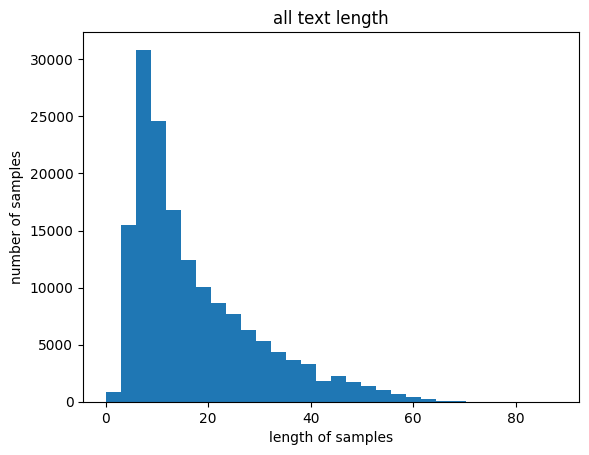

In [35]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [37]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [38]:
X_train[1] # 길이가 40 미만이라면 나머지 요소는 0 패딩

array([    0,     0,     0,     0,     0,  2272,   480,     7,   139,
         297,  9465,   344,    16, 10115,  6359, 13195,   206,    16,
          59,   425,   151,   229,     3, 10115,   659,  3804,    76,
          13,    53,  1130,   538,    26,   230,     3,    24,   370,
          28,  1400,   262,     4], dtype=int32)

In [56]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)
    # model.lower()에 해당하는 모델을 불러오고, model_params의 value 값들을 언패킹
    # *가 하나면 key 값들을 언패킹

### DataLoader 생성

In [57]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [58]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [65]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # embedding_dim이 아니라 hidden_dim이지 않을까?
        # 아래코드가 정상작동하는 이유는 embedding_dim과 hidden_dim이 같아서

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        # text.size(0): batch_size
        # 그래디언트 계산이 필요함을 명시
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())
        # 순전파 수행 시 그래디언트 분리

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size(마지막 time step의 output)

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [66]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()
# 분류 문제이므로 crossentropy loss를 선택한다.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [67]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.4019876718521118. Accuracy: 86.62898254394531
Iteration: 1000. Loss: 0.33530789613723755. Accuracy: 87.92456817626953
Iteration: 1500. Loss: 0.3354904055595398. Accuracy: 89.17012786865234
Iteration: 2000. Loss: 0.19858607649803162. Accuracy: 89.37271881103516
Iteration: 2500. Loss: 0.11455047875642776. Accuracy: 89.41023254394531
Iteration: 3000. Loss: 0.23967774212360382. Accuracy: 88.51483154296875
Iteration: 3500. Loss: 0.25440797209739685. Accuracy: 89.05757904052734
Iteration: 4000. Loss: 0.42965206503868103. Accuracy: 86.51393127441406
Iteration: 4500. Loss: 0.2737867534160614. Accuracy: 88.72992706298828
Iteration: 5000. Loss: 0.19556394219398499. Accuracy: 89.82041931152344
Iteration: 5500. Loss: 0.20139995217323303. Accuracy: 89.2901840209961
Iteration: 6000. Loss: 0.3882918655872345. Accuracy: 88.81246948242188
Iteration: 6500. Loss: 0.39446693658828735. Accuracy: 88.8149642944336
Iteration: 7000. Loss: 0.2825404107570648. Accuracy: 88.25971984863281


### 모델학습 (LSTM, Long short term memory)

In [71]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # hidden_dim으로 바꾸어 줌

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [72]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [73]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.24179477989673615. Accuracy: 90.77334594726562
Iteration: 2000. Loss: 0.20345626771450043. Accuracy: 91.43864440917969
Iteration: 3000. Loss: 0.2086331695318222. Accuracy: 91.82131958007812
Iteration: 4000. Loss: 0.2967749834060669. Accuracy: 91.66625213623047
Iteration: 5000. Loss: 0.06529008597135544. Accuracy: 91.7587890625
Iteration: 6000. Loss: 0.18360258638858795. Accuracy: 91.7237777709961
Iteration: 7000. Loss: 0.26384666562080383. Accuracy: 91.48117065429688
Iteration: 8000. Loss: 0.19218476116657257. Accuracy: 91.38862609863281
Iteration: 9000. Loss: 0.2061489075422287. Accuracy: 91.44114685058594
Iteration: 10000. Loss: 0.06315268576145172. Accuracy: 91.2535629272461
Iteration: 11000. Loss: 0.16770882904529572. Accuracy: 91.35360717773438
Iteration: 12000. Loss: 0.13900722563266754. Accuracy: 91.34110260009766
Iteration: 13000. Loss: 0.10620710998773575. Accuracy: 90.7708511352539
Iteration: 14000. Loss: 0.09301724284887314. Accuracy: 91.048469543457

### 모델 학습 (Gated Recurrent Unit (GRU))

In [74]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)
        # hidden_dim으로 변경

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [75]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [76]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.20035827159881592. Accuracy: 90.58576202392578
Iteration: 2000. Loss: 0.19453656673431396. Accuracy: 91.0284652709961
Iteration: 3000. Loss: 0.1521155834197998. Accuracy: 91.63874053955078
Iteration: 4000. Loss: 0.22037695348262787. Accuracy: 91.6512451171875
Iteration: 5000. Loss: 0.16678614914417267. Accuracy: 91.77379608154297
Iteration: 6000. Loss: 0.07603560388088226. Accuracy: 91.63123321533203
Iteration: 7000. Loss: 0.13485775887966156. Accuracy: 91.46366119384766
Iteration: 8000. Loss: 0.0976356565952301. Accuracy: 91.46366119384766
Iteration: 9000. Loss: 0.16364505887031555. Accuracy: 91.35111236572266
Iteration: 10000. Loss: 0.2045731544494629. Accuracy: 91.20104217529297
Iteration: 11000. Loss: 0.19258373975753784. Accuracy: 90.60076904296875
Iteration: 12000. Loss: 0.09364661574363708. Accuracy: 91.21354675292969
Iteration: 13000. Loss: 0.11636056005954742. Accuracy: 90.8733901977539
Iteration: 14000. Loss: 0.11331330239772797. Accuracy: 91.01845550

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

## LSTM

In [77]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 2   # Layer 수를 늘려 깊은 패턴 파악 시도
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
# Adam 옵티마이저의 변형인 AdamW로 변경.
criterion = nn.CrossEntropyLoss()

In [78]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.12779481709003448. Accuracy: 90.77835083007812
Iteration: 2000. Loss: 0.31145092844963074. Accuracy: 91.4161376953125
Iteration: 3000. Loss: 0.16320401430130005. Accuracy: 91.53118896484375
Iteration: 4000. Loss: 0.3501318097114563. Accuracy: 91.73127746582031
Iteration: 5000. Loss: 0.0614018589258194. Accuracy: 91.92386627197266
Iteration: 6000. Loss: 0.1879623532295227. Accuracy: 91.78630828857422
Iteration: 7000. Loss: 0.3882984519004822. Accuracy: 92.01390838623047
Iteration: 8000. Loss: 0.10190068185329437. Accuracy: 91.74378204345703
Iteration: 9000. Loss: 0.09572168439626694. Accuracy: 91.7187728881836
Iteration: 10000. Loss: 0.06593053787946701. Accuracy: 91.71127319335938
Iteration: 11000. Loss: 0.11794087290763855. Accuracy: 91.78380584716797
Iteration: 12000. Loss: 0.19037863612174988. Accuracy: 91.62873077392578
Iteration: 13000. Loss: 0.04254855588078499. Accuracy: 91.4936752319336
Iteration: 14000. Loss: 0.09764936566352844. Accuracy: 91.278579711

## Vanilla RNN

In [79]:
# 같은 파라미터와 옵티마이저로 다른 모델도 시도
model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
criterion = nn.CrossEntropyLoss()

In [80]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.3298303484916687. Accuracy: 86.64649200439453
Iteration: 1000. Loss: 0.29354166984558105. Accuracy: 87.67445373535156
Iteration: 1500. Loss: 0.6087950468063354. Accuracy: 88.5948715209961
Iteration: 2000. Loss: 0.23493561148643494. Accuracy: 88.3222427368164
Iteration: 2500. Loss: 0.29911112785339355. Accuracy: 87.99459838867188
Iteration: 3000. Loss: 0.28718459606170654. Accuracy: 88.30973815917969
Iteration: 3500. Loss: 0.5301793813705444. Accuracy: 88.9825439453125
Iteration: 4000. Loss: 0.2901460826396942. Accuracy: 88.63739013671875
Iteration: 4500. Loss: 0.3375944197177887. Accuracy: 88.46981048583984
Iteration: 5000. Loss: 0.2545052468776703. Accuracy: 88.75494384765625
Iteration: 5500. Loss: 0.3798214793205261. Accuracy: 88.6348876953125
Iteration: 6000. Loss: 0.2051054984331131. Accuracy: 89.04507446289062
Iteration: 6500. Loss: 0.28853344917297363. Accuracy: 87.38682556152344
Iteration: 7000. Loss: 0.3633687198162079. Accuracy: 88.77494812011719
Iterat

## GRU

In [81]:
model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
criterion = nn.CrossEntropyLoss()

In [82]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.34013327956199646. Accuracy: 90.93092346191406
Iteration: 2000. Loss: 0.31418320536613464. Accuracy: 91.54119110107422
Iteration: 3000. Loss: 0.13464486598968506. Accuracy: 91.51117706298828
Iteration: 4000. Loss: 0.3249921202659607. Accuracy: 91.58871459960938
Iteration: 5000. Loss: 0.2128017693758011. Accuracy: 91.71627044677734
Iteration: 6000. Loss: 0.2574942708015442. Accuracy: 91.61872863769531
Iteration: 7000. Loss: 0.17621544003486633. Accuracy: 91.79881286621094
Iteration: 8000. Loss: 0.19119493663311005. Accuracy: 91.31609344482422
Iteration: 9000. Loss: 0.1258089244365692. Accuracy: 91.31859588623047
Iteration: 10000. Loss: 0.10614557564258575. Accuracy: 91.57120513916016
Iteration: 11000. Loss: 0.13718503713607788. Accuracy: 91.5386962890625
Iteration: 12000. Loss: 0.21380916237831116. Accuracy: 91.36861419677734
Iteration: 13000. Loss: 0.20209379494190216. Accuracy: 91.31859588623047
Iteration: 14000. Loss: 0.10043402761220932. Accuracy: 91.1785278

> 모델 학습 양상을 보면, 반복이 거듭될 수록 과적합되는 경향성을 보여, 이를 줄이고자 드롭아웃 확률을 낮추고, 레이어 수를 다시 1, L2 정규화를 위해 옵티마이저에  weight_decay 인자를 추가한다.

## LSTM

In [87]:

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.35, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [88]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.2020898312330246. Accuracy: 90.82086944580078
Iteration: 2000. Loss: 0.2952408492565155. Accuracy: 91.4561538696289
Iteration: 3000. Loss: 0.1076328456401825. Accuracy: 91.47116088867188
Iteration: 4000. Loss: 0.28107598423957825. Accuracy: 91.91636657714844
Iteration: 5000. Loss: 0.28095945715904236. Accuracy: 92.09394073486328
Iteration: 6000. Loss: 0.12322814017534256. Accuracy: 91.79631042480469
Iteration: 7000. Loss: 0.21709954738616943. Accuracy: 91.57120513916016
Iteration: 8000. Loss: 0.10105407983064651. Accuracy: 91.55120086669922
Iteration: 9000. Loss: 0.2727281153202057. Accuracy: 91.56120300292969
Iteration: 10000. Loss: 0.15401363372802734. Accuracy: 91.63373565673828
Iteration: 11000. Loss: 0.11630470305681229. Accuracy: 91.27357482910156
Iteration: 12000. Loss: 0.09493739157915115. Accuracy: 91.25106048583984
Iteration: 13000. Loss: 0.03901863470673561. Accuracy: 91.09599304199219
Iteration: 14000. Loss: 0.18885919451713562. Accuracy: 90.9459228

## Vanilla RNN

In [89]:
# 같은 파라미터와 옵티마이저로 다른 모델도 시도
model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [90]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.36730408668518066. Accuracy: 86.9366226196289
Iteration: 1000. Loss: 0.32997697591781616. Accuracy: 85.99119567871094
Iteration: 1500. Loss: 0.29354971647262573. Accuracy: 88.2772216796875
Iteration: 2000. Loss: 0.3052234351634979. Accuracy: 89.00755310058594
Iteration: 2500. Loss: 0.3710641860961914. Accuracy: 85.08329010009766
Iteration: 3000. Loss: 0.1970439851284027. Accuracy: 87.84953308105469
Iteration: 3500. Loss: 0.2934802174568176. Accuracy: 87.75949096679688
Iteration: 4000. Loss: 0.3016020655632019. Accuracy: 88.9325180053711
Iteration: 4500. Loss: 0.39250436425209045. Accuracy: 89.40023040771484
Iteration: 5000. Loss: 0.26539182662963867. Accuracy: 87.7544937133789
Iteration: 5500. Loss: 0.48853209614753723. Accuracy: 66.83757781982422
Iteration: 6000. Loss: 0.26266083121299744. Accuracy: 88.08714294433594
Iteration: 6500. Loss: 0.280817449092865. Accuracy: 86.70401763916016
Iteration: 7000. Loss: 0.2764720618724823. Accuracy: 86.36386108398438
Itera

## GRU

In [91]:
model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [92]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.22182691097259521. Accuracy: 90.89089965820312
Iteration: 2000. Loss: 0.22841031849384308. Accuracy: 91.59121704101562
Iteration: 3000. Loss: 0.1096697598695755. Accuracy: 91.66875457763672
Iteration: 4000. Loss: 0.14495296776294708. Accuracy: 91.78380584716797
Iteration: 5000. Loss: 0.10581767559051514. Accuracy: 91.91636657714844
Iteration: 6000. Loss: 0.11594346910715103. Accuracy: 91.51367950439453
Iteration: 7000. Loss: 0.18850156664848328. Accuracy: 91.73377990722656
Iteration: 8000. Loss: 0.059973377734422684. Accuracy: 91.5386962890625
Iteration: 9000. Loss: 0.23091335594654083. Accuracy: 91.5386962890625
Iteration: 10000. Loss: 0.14131543040275574. Accuracy: 91.4111328125
Iteration: 11000. Loss: 0.042779866605997086. Accuracy: 91.18853759765625
Iteration: 12000. Loss: 0.0588136687874794. Accuracy: 91.03346252441406
Iteration: 13000. Loss: 0.10812336206436157. Accuracy: 91.25106048583984
Iteration: 14000. Loss: 0.13226260244846344. Accuracy: 90.77334594

> 과적합 방지를 시도한 파라미터 조정에서 LSTM 모델이 92%대의 정확도를 보이는 순간이 있지만. 이는 반복 학습 초기에 해당하며 로스값도 높아 신뢰할 수 없는 결과로 해석된다.  
전반적으로 LSTM와 GRU는 매우 비슷한 성능을 보이며, Vanilla RNN은 조금 떨어지는 성능을 확인할 수 있다.  
파라미터를 조정하면서 확인할 수 있는 사실은, 학습 후반에는 과적합 문제로 학습 안정성과 모델 성능이 전반적으로 떨어지는 것을 확인할 수 있다.  
이는 에폭수를 줄이거나, 배치 크기를 늘리는 등의 과적합을 줄이는 다른 시도도 해볼 수 있을 것으로 판단된다.  